# Arbitrage Betting Strategies
---
- Author: Matthew Thoomkuzhy

- Date: 29/01/2025

- Aim: To investigate the nature of arbitrage opportunities over the smaple, to inform and devise an arbitrage betting strategy (this will be bakctested in NB05)
---

# 1. Introduction

This notebook will largely consist of exploratory daata analysis where we explore and identify patterns involving arbitrage opportunities for premier league matches from 2020 to 2025

**Key questions I aim to answer:**



- How has the prevelance of arbitrage opportunities changed over time?, is it periodic? (i.e. more opportunites at the start of every season)


- When arbitrage opportunities are present what is the distribution of odds differences among outcomes, is there a clear favourite or are the games implicitly 'close'


- How do full time results vary with odds differences, can this information be used to inform when to use biased vs unbiased arbitrage?



---
# 2. Importing Libraries

In [60]:
from functions import process_row , process_odds_data # from functions.py
import pandas as pd
from sqlalchemy import create_engine
from lets_plot import * 
from lets_plot import ggsave
from IPython.display import SVG
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns

---
# 3.  Obtaining DF from DB

In [50]:
engine = create_engine('sqlite:///../data/sports_odds.db')
odds_df = pd.read_sql('SELECT * FROM historical_odds', con=engine)
results_df = pd.read_sql('SELECT * FROM match_results', con=engine)

# Using imported functions to get DF
merged_df = process_odds_data(odds_df, results_df,process_row)
merged_df 


,fixture_id,Date,home_team,away_team,FTR,max_home,home_bookmaker,max_away,away_bookmaker,max_draw,draw_bookmaker
0,AVLSHU170620,17/06/2020,Aston Villa,Sheffield United,D,3.35,Unibet,2.41,Marathon Bet,3.52,Marathon Bet
1,MCIARS170620,17/06/2020,Manchester City,Arsenal,H,1.39,Marathon Bet,8.70,Marathon Bet,5.95,Marathon Bet
2,TOTMUN190620,19/06/2020,Tottenham Hotspur,Manchester United,D,2.88,Betfair,2.64,Marathon Bet,3.70,Marathon Bet
3,WATLEI200620,20/06/2020,Watford,Leicester City,D,3.52,Marathon Bet,2.22,Marathon Bet,3.75,Marathon Bet
4,WHUWOL200620,20/06/2020,West Ham United,Wolverhampton Wanderers,A,3.70,Betfair,2.23,Marathon Bet,3.60,Marathon Bet
...,...,...,...,...,...,...,...,...,...,...,...
1777,FULARS081224,08/12/2024,Fulham,Arsenal,D,6.40,Smarkets,1.62,BoyleSports,4.33,Sky Bet
1778,IPSBOU081224,08/12/2024,Ipswich Town,Bournemouth,A,3.20,Paddy Power,2.20,Smarkets,3.90,Betfair
1779,LEIBHA081224,08/12/2024,Leicester City,Brighton and Hove Albion,D,5.00,Paddy Power,1.73,BoyleSports,4.40,Coral
1780,TOTCHE081224,08/12/2024,Tottenham Hotspur,Chelsea,A,2.30,Paddy Power,3.10,Smarkets,3.75,Sky Bet


---
# 4.) prevalence of arbitrage opportunities over time

Now I am going to be implementing code logic for arbitrage opportunities,
grouping opportunities for each event by commence time and
then plotting a time series graph for the prevalence of arbitrage opportunities over time

**Code for arbitrage logic**:

- I implement the formula (1/oddsH + 1/oddsD + 1/oddsA) for each event and check if < or > 1, if less than one, then an arbitrage opportunity exists.

C:\Users\jogim\AppData\Local\Temp\ipykernel_6916\2848309231.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


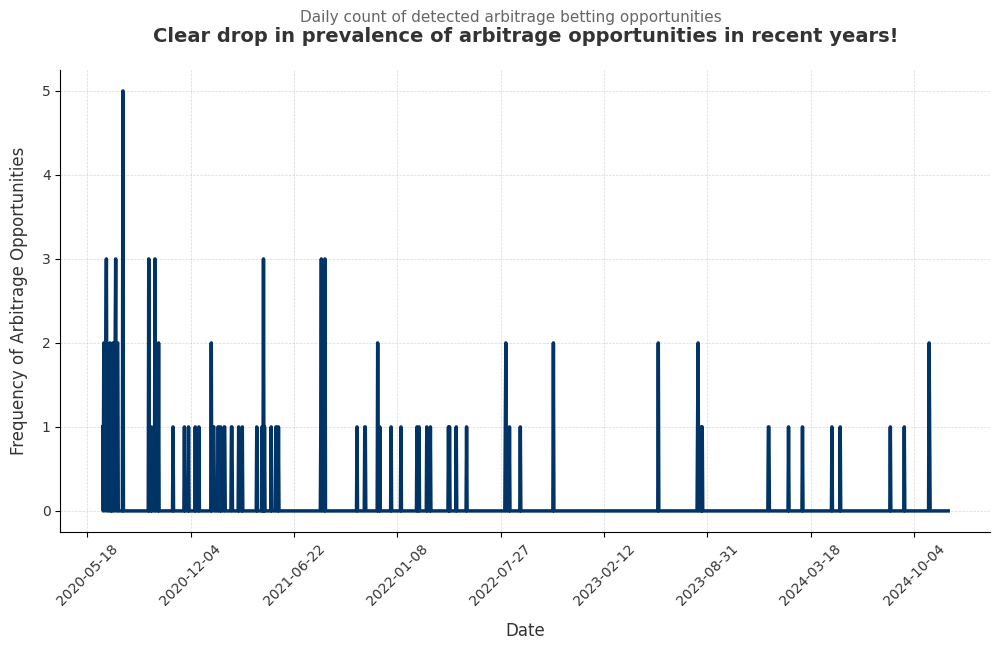

In [ ]:


def plot_arbitrage_over_time(df):
    """
    Identifies arbitrage opportunities for each fixture and plots their frequency over time
    with a clean, McKinsey-style professional aesthetic. Optimized using `groupby().apply()` and `combine()`.

    Parameters:
    - df (pd.DataFrame): DataFrame containing fixture odds data.

    Returns:
    - None (displays a polished line chart)
    """
    # Ensure required columns exist
    required_columns = {"Date", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

    # Copy dataframe to avoid modifying the original
    df = df.copy()

    # Convert Date column to datetime format
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

    # Filter out invalid odds (0 or NaN)
    df = df.dropna(subset=["max_home", "max_away", "max_draw"])
    df = df[(df["max_home"] > 0) & (df["max_away"] > 0) & (df["max_draw"] > 0)]

    # **Optimized arbitrage detection using groupby + apply**
    def check_arbitrage(group):
        # Use .combine() to efficiently compute arbitrage across all rows in group
        arb_values = (1 / group["max_home"]).combine(
            (1 / group["max_away"]), func=lambda x, y: x + y
        ).combine(
            (1 / group["max_draw"]), func=lambda x, y: x + y
        )
        return (arb_values < 1).sum()  # Count arbitrage opportunities in the group

    # Apply group-wise arbitrage detection
    arb_freq = df.groupby("Date").apply(check_arbitrage)

    # Ensure all dates are represented in the time series
    arb_freq = arb_freq.resample("D").sum().fillna(0)

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.plot(arb_freq.index, arb_freq.values, color="#003366", linewidth=2.5)

    # Titles and labels
    plt.title("Clear drop in prevalence of arbitrage opportunities in recent years!", fontsize=14, fontweight="bold", pad=20, color="#333333")
    plt.suptitle("Daily count of detected arbitrage betting opportunities", fontsize=11, color="#666666")

    plt.xlabel("Date", fontsize=12, color="#333333", labelpad=10)
    plt.ylabel("Frequency of Arbitrage Opportunities", fontsize=12, color="#333333", labelpad=10)

    # Grid with subtlety
    plt.grid(which="major", linestyle="--", linewidth=0.5, alpha=0.5)

    # Adjust x-axis for cleaner date formatting
    plt.xticks(rotation=45, fontsize=10, color="#333333")
    plt.yticks(fontsize=10, color="#333333")
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))  # Limits number of x-ticks

    # Remove chart border for cleaner look
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    # Save plot as a file
    plt.savefig("arbitrage_density_plot.png", bbox_inches='tight')

    # Display the plot
    plt.show()
    


# Apply the function to the dataset
plot_arbitrage_over_time(merged_df)


### Insight: 

Visually we can see there has been a large dropoff in the number of abritrage opportunities detected daily. Previously there were many days where 2+, 3+ daily opportunities where present whereas now there are long periods where no opportunities are detected at all!

**Informing NB05 strategy:** The data shows arb may yield lucrative for 2020 but for more recent years the effectvieness of arbitrage is lower

**this may suggests the bookies are becoming more co-ordinated in their odds offerred and arbitrage is dying**

To investigate this further I want to investigate the **profit margins of arbitrage**, a fall in profit margins from arbitrage could be indiciative of lower odds deviation between bookmakers:

---
# 5.) investigating how profit margins have varied over time

1. To investigate how faily profit margins are varying I have worked out the most profitable event in each day of the sample.

2. I then used this as an indication of the profitability of that day (days wiht no arb opportunities would be zero)

3. I have decided against using a geometric total for days with >1 arb. ie. multiplying profit margins for each event in that day together. This is as events ususally clash in time due to match scheduling, therefore its impossible to bet on both events simultaneously wihout splitting funds from an inital bankroll

**Logic for profit margins**


I implement the formula 100 x  (1- (1/oddsH + 1/oddsD + 1oddsA)) for each arbitrage event to work out the profit margin (%) of that event

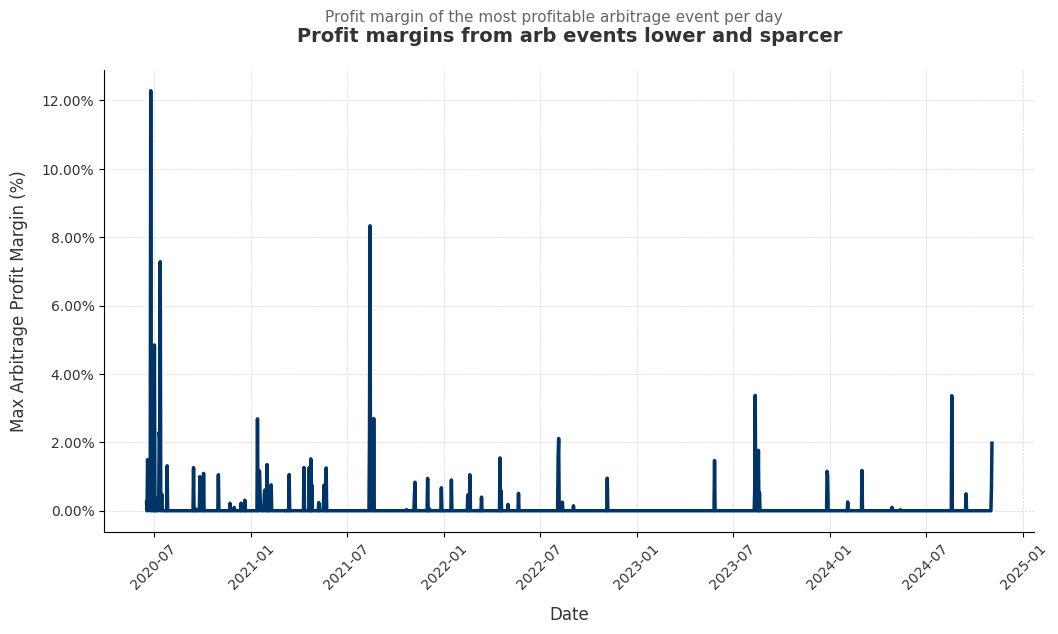

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_max_arbitrage_profitability(df):
    """
    Computes and plots the maximum arbitrage profit margin per day.
    If no arbitrage event exists on a day, the profit margin is set to 0.

    Parameters:
    - df (pd.DataFrame): DataFrame containing fixture odds data.

    Returns:
    - None (displays a time series plot)
    """
    required_columns = {"Date", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

    df = df.dropna(subset=["max_home", "max_away", "max_draw"])
    df = df[(df["max_home"] > 0) & (df["max_away"] > 0) & (df["max_draw"] > 0)]

    df["arbitrage_margin"] = 1 - ((1 / df["max_home"]) + (1 / df["max_away"]) + (1 / df["max_draw"]))
    df = df[df["arbitrage_margin"] > 0]

    # Get the most profitable arbitrage event per day
    daily_max_profit = df.groupby("Date")["arbitrage_margin"].max()

    # Reindex to include all days, filling missing values with 0
    daily_max_profit = daily_max_profit.reindex(pd.date_range(df["Date"].min(), df["Date"].max()), fill_value=0)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(daily_max_profit.index, daily_max_profit.values, color="#003366", linewidth=2.5)

    plt.title("Profit margins from arb events lower and sparcer", fontsize=14, fontweight="bold", pad=20, color="#333333")
    plt.suptitle("Profit margin of the most profitable arbitrage event per day", fontsize=11, color="#666666")

    plt.xlabel("Date", fontsize=12, color="#333333", labelpad=10)
    plt.ylabel("Max Arbitrage Profit Margin (%)", fontsize=12, color="#333333", labelpad=10)

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:.2f}%"))
    plt.grid(which="major", linestyle="--", linewidth=0.5, alpha=0.5)

    plt.xticks(rotation=45, fontsize=10, color="#333333")
    plt.yticks(fontsize=10, color="#333333")

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    # Save plot as a file
    plt.savefig("arbitrage_density_plot.png", bbox_inches='tight')

    plt.show() 
    


plot_max_arbitrage_profitability(merged_df)


### Insight:

We can clearly see that the scarcity of profitable days has fallen as expected in line with the frequency of opportunities per day shown in the prior plot

Reinforcing the view that arbitrage opportunities are 'dying out'

**Informing NB05 strategy:** The data shows arb may yield lucrative for 2020 but for more recent years the effectvieness of arbitrage is lower

One noticebale pattern is a **relative spike in arbitrage opportunities in August/September each year**, I want to investigate this further.

---
# 6.) investigating seasonal distribution of opportunities

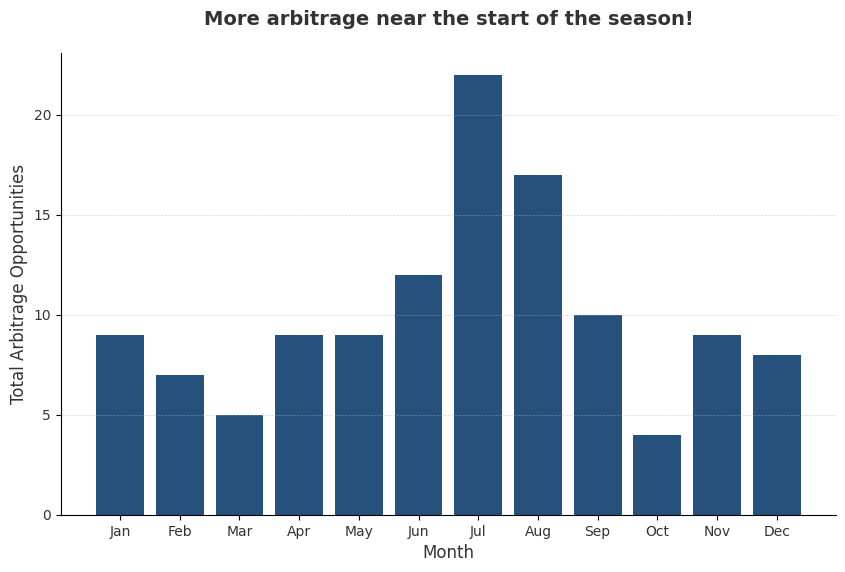

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_arbitrage_opportunities_by_month(df):
    """
    Plots the total number of arbitrage opportunities by month (aggregated across all years).

    Parameters:
    - df (pd.DataFrame): DataFrame containing fixture odds data.

    Returns:
    - None (displays a bar chart)
    """
    required_columns = {"Date", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

    df = df.dropna(subset=["max_home", "max_away", "max_draw"])
    df = df[(df["max_home"] > 0) & (df["max_away"] > 0) & (df["max_draw"] > 0)]

    df["arbitrage_margin"] = 1 - ((1 / df["max_home"]) + (1 / df["max_away"]) + (1 / df["max_draw"]))
    df["Month"] = df["Date"].dt.month  # Extract month as a number

    # Count arbitrage occurrences per month (regardless of year)
    monthly_arb_counts = df[df["arbitrage_margin"] > 0]["Month"].value_counts().sort_index()

    # Define month names for better readability
    month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(month_labels, monthly_arb_counts, color="#003366", alpha=0.85)

    plt.title("More arbitrage near the start of the season!", fontsize=14, fontweight="bold", pad=20, color="#333333")
    plt.xlabel("Month", fontsize=12, color="#333333")
    plt.ylabel("Total Arbitrage Opportunities", fontsize=12, color="#333333")

    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.5)
    plt.xticks(fontsize=10, color="#333333")
    plt.yticks(fontsize=10, color="#333333")

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    # Save plot as a file
    plt.savefig("arbitrage_density_plot.png", bbox_inches='tight')

    plt.show()
    


# Example Usage:
plot_arbitrage_opportunities_by_month(merged_df)


### Insight:

The clear spike in the number of arbitrage opportunities in June July and August (the 3 most popular months) implies that **arbitrage is most effective at the start of the season**

This is likely due to **greater uncertainty at the start of the season** as to who has a stronger and weaker team, and less recent form data means that bookmakers will show **greater deviations in pricing odds**.

**Informing NB05 strategy:** The data shows that a higher weighting should be placed on arbitrage during the early season months due to their increased frequency

I want to further investigate deviations in pricing odds.

---
# 7.) Nature of odds pricing in arbitrage events

First I begin by calculating the size of the sample for arbitrage games

In [54]:
# Ensure arbitrage margin is calculated
merged_df["arbitrage_margin"] = 1 - ((1 / merged_df["max_home"]) + (1 / merged_df["max_away"]) + (1 / merged_df["max_draw"]))

# Ensure only valid arbitrage opportunities are counted
total_arb_opportunities = (merged_df["arbitrage_margin"] > 0).sum()

print("Total Arbitrage Opportunities:", total_arb_opportunities)


Total Arbitrage Opportunities: 121


121 is a sufficiently large sample (of arbitrage matches) to draw observations regarding the nature of arbitrage

First I want to investigate the odds difference for arbitrage events by plottign the desnity of odds difference for arbitrage events

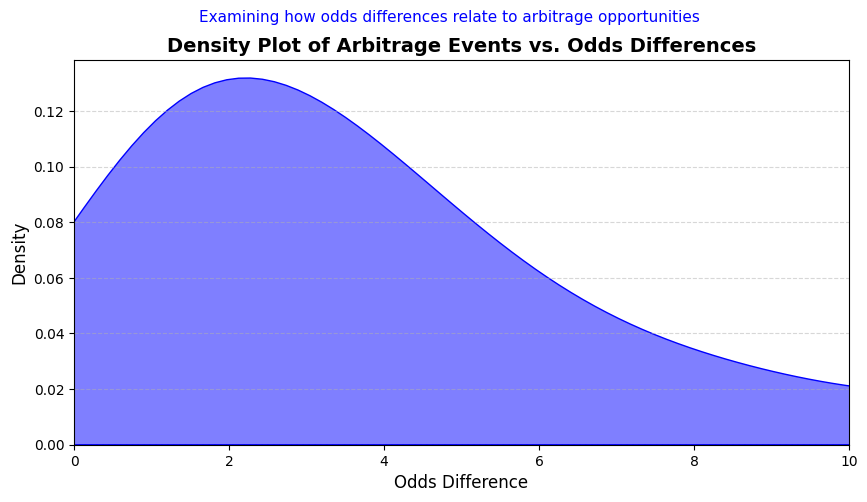

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure valid odds (avoiding division by zero errors)
merged_df = merged_df.copy()
merged_df = merged_df.dropna(subset=["max_home", "max_away", "max_draw"])
merged_df = merged_df[(merged_df["max_home"] > 0) & (merged_df["max_away"] > 0) & (merged_df["max_draw"] > 0)]

# Calculate arbitrage margin
merged_df["arbitrage_margin"] = 1 - ((1 / merged_df["max_home"]) + (1 / merged_df["max_away"]) + (1 / merged_df["max_draw"]))

# Filter only arbitrage events
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()

# Compute odds difference
arb_events_df['odds_difference'] = abs(arb_events_df['max_home'] - arb_events_df['max_away'])

# Plot density curve
plt.figure(figsize=(10, 5))
sns.kdeplot(arb_events_df['odds_difference'], fill=True, color='blue', alpha=0.5)

# Formatting
plt.xlim(0, 10)
plt.xlabel("Odds Difference", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Density Plot of Arbitrage Events vs. Odds Differences", fontsize=14, fontweight='bold')
plt.suptitle("Examining how odds differences relate to arbitrage opportunities", fontsize=11, color='blue')

# Display plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Save plot as a file
plt.savefig("arbitrage_density_plot.png", bbox_inches='tight')
